# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from darwinian_shift import DarwinianShift, BinomTest
from darwinian_shift import UniprotLookup, get_bins_for_uniprot_features, plot_domain_structure
from darwinian_shift import hide_top_and_right_axes

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [3]:
d_skin = DarwinianShift(
    data = pd.read_excel('248092_3_supp_6645104_q35h43.xlsx', sheet_name='Table S4', skiprows=4),
    source_genome='GRCh37',
    spectra='skin_trinuc_spectrum.txt',
    statistics=BinomTest()
)

In [4]:
d_oe = DarwinianShift(
    data=pd.read_excel('aau3879_TableS2.xlsx',
                       sheet_name='Mutations_collapsed_by_distance', skiprows=17),
    source_genome='GRCh37',
    spectra='oesophagus_trinuc_spectrum.txt',
    statistics=BinomTest()
)

# Missense mutations per domain

In [5]:
# Colours 
egf_colour = '#88CCEE'
egf_11_12_colour = '#0077BB'
LNR_colour = '#EE7733'
ANK_colour = '#009988'
transmembrane_colour = '#CC3311'
non_domain_colour = '#888888' 

In [6]:
# Use UniProt data to define domain boundaries
u = UniprotLookup(
    transcript_uniprot_mapping={'ENST00000277541': 'P46531'}  # Must manually define the correct mapping for NOTCH1
)
NOTCH1_uniprot = u.get_uniprot_data('ENST00000277541')

In [7]:
notch1_skin = d_skin.make_section(gene='NOTCH1', included_mutation_types='missense')

In [8]:
last_residue = notch1_skin.null_mutations['residue'].max()

# Get the boundaries of "domains", "repeats" and the transmembrane region from the UniProt data
bins, types, descriptions = get_bins_for_uniprot_features(NOTCH1_uniprot, min_gap=1, last_residue=last_residue, 
                                                         feature_types=['domain', 'transmembrane region', 'repeat'])

# Assign colours to each domain
colours = []
for t, desc in zip(types, descriptions):
    if desc in ['EGF-like 11; calcium-binding', 'EGF-like 12; calcium-binding']:
        colours.append(egf_11_12_colour)
    elif t == 'domain':
        colours.append(egf_colour)
    elif t == 'repeat':
        if 'LNR' in desc:
            colours.append(LNR_colour)
        elif 'ANK' in desc:
            colours.append(ANK_colour)
    elif t == 'transmembrane region':
        colours.append(transmembrane_colour)
    elif t is None and desc is None:
        colours.append(non_domain_colour)

colours_domain_plot = [None if c == non_domain_colour else c for c in colours]

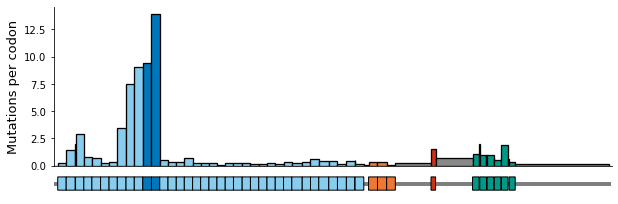

In [9]:
# Plot for skin

fig, (ax1, ax_dom) = plt.subplots(2, 1, figsize=(10, 3.5), sharex=True, 
                                       gridspec_kw={'height_ratios': (3, 0.5), 'hspace': 0.05})
linewidth = 1.3
notch1_skin.plot_bar_observations(binning_regions=bins, 
             normalise_by_region_size=True, facecolour=colours, linewidth=linewidth, ax=ax1)
ax1.set_xlim([0, last_residue+10])
hide_top_and_right_axes(ax1)
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_ylabel('Mutations per codon', fontsize=13)

plot_domain_structure(bins, colours_domain_plot, height=1, ax=ax_dom)

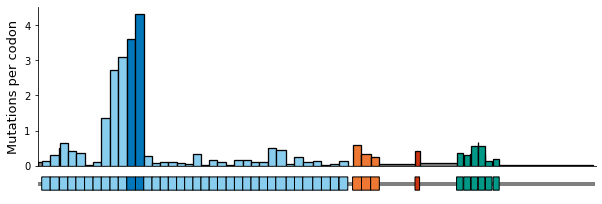

In [10]:
# plot for oesophagus

notch1_oe = d_oe.make_section(gene='NOTCH1', included_mutation_types='missense')

fig, (ax1, ax_dom) = plt.subplots(2, 1, figsize=(10, 3.5), sharex=True, 
                                       gridspec_kw={'height_ratios': (3, 0.5), 'hspace': 0.05})
linewidth = 1.3
notch1_oe.plot_bar_observations(binning_regions=bins, 
             normalise_by_region_size=True, facecolour=colours, linewidth=linewidth, ax=ax1)
ax1.set_xlim([0, last_residue+10])
hide_top_and_right_axes(ax1)
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_ylabel('Mutations per codon', fontsize=13)

plot_domain_structure(bins, colours_domain_plot, height=1, ax=ax_dom)

# Missense mutations sliding window

In [11]:
# Colours
unobserved_colour = '#636363'
observed_colour = '#EE7733'

In [12]:
notch1_section = {'transcript_id': 'ENST00000277541', 'included_mutation_types': 'missense'}

## SMS

In [13]:
s = d_skin.make_section(notch1_section)

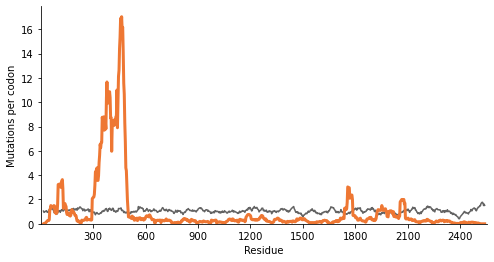

In [14]:
s.plot_sliding_window(show_legend=False, colours=[observed_colour, unobserved_colour], 
                                   figsize=(8, 4), window_size=30, window_step=3)
hide_top_and_right_axes()

## OE

In [15]:
s = d_oe.make_section(notch1_section)

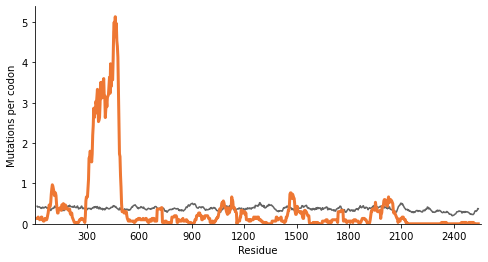

In [16]:
s.plot_sliding_window(show_legend=False, colours=[observed_colour, unobserved_colour], 
                                   figsize=(8, 4), window_size=30, window_step=3)
hide_top_and_right_axes()

# Testing synonymous mutation enrichment in EGF11-12

In [17]:
from darwinian_shift import SequenceDistanceLookup

In [18]:
section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 
    'included_mutation_types': 'synonymous',
    'target_selection': np.arange(412, 488)
}

In [19]:
S = SequenceDistanceLookup(boolean=True)

## SMS

In [20]:
s = d_skin.run_section(section_definition_egf11_12, lookup=S)

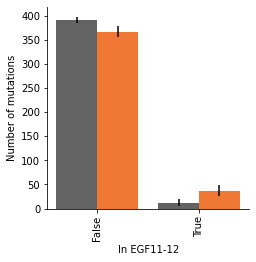

In [21]:
s.plot_binned_counts(figsize=(4, 4), colours=[observed_colour, unobserved_colour], 
                                          show_legend=False, bins=[-1, 0.5, 2])
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('In EGF11-12')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)

In [22]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': 'ENST00000277541',
 'num_mutations': 404,
 'observed_median': 0.0,
 'observed_mean': 0.09158415841584158,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.030648704942022747,
 'mean_shift_glob_k3': 0.06093545347381883,
 'binom_glob_k3_pvalue': 5.632274781926942e-09,
 'binom_glob_k3_expected_proportion': 0.030648704942022747,
 'binom_glob_k3_observed_proportion': 0.09158415841584158,
 'binom_glob_k3_expected_count': 12.38207679657719,
 'binom_glob_k3_observed_count': 37,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 19.0,
 'binom_glob_k3_expected_CI_low': 6.0,
 'binom_glob_k3_observed_CI_low': 26.0,
 'binom_glob_k3_observed_CI_high': 49.0}

## OE

In [23]:
s = d_oe.run_section(section_definition_egf11_12, lookup=S)

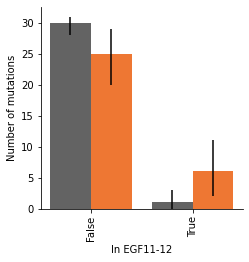

In [24]:
s.plot_binned_counts(figsize=(4, 4), colours=[observed_colour, unobserved_colour], 
                                          show_legend=False, bins=[-1, 0.5, 2])
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('In EGF11-12')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)

In [25]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': 'ENST00000277541',
 'num_mutations': 31,
 'observed_median': 0.0,
 'observed_mean': 0.1935483870967742,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.032985125061272436,
 'mean_shift_glob_k3': 0.16056326203550175,
 'binom_glob_k3_pvalue': 0.00046553680030253074,
 'binom_glob_k3_expected_proportion': 0.03298512506127243,
 'binom_glob_k3_observed_proportion': 0.1935483870967742,
 'binom_glob_k3_expected_count': 1.0225388768994452,
 'binom_glob_k3_observed_count': 6,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 3.0,
 'binom_glob_k3_expected_CI_low': 0.0,
 'binom_glob_k3_observed_CI_low': 2.0,
 'binom_glob_k3_observed_CI_high': 10.0}